In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-07-20 00:57:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-20 00:57:27 (69.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Loading and Pre-processing the data.
Downloads and processes the CoNLL-2003 dataset for Named Entity Recognition (NER).
1. Downloads GloVe word embeddings (100-dimensional).
2. Creates a vocabulary map from tokens to indices.
3. Processes the CoNLL files to create labeled windows of tokens.
4. Generates index files for each CoNLL dataset file.
5. Creates special tokens and adds them to the vocabulary.
6. Exports the vocabulary and label mappings to separate files.

The script uses a sliding window approach to create context for each token in the dataset. It handles file downloading, data extraction, and preprocessing to prepare the data for use in NER tasks. The output includes indexed versions of the CoNLL files, a vocabulary map, and a label map, which can be used for training and evaluating NER models.


In [2]:
import gzip
import os
import urllib.request
import zipfile
import numpy as np

# Define constants
window = 2
vocab = {}
labels = {}
w2v_file = 'glove.6B.100d.txt'
vector_out_file = 'glove.6B.100d.index'
data_dir = 'conll2003/'
vocab_map_file = 'vocab-map.index'
label_map_file = 'label-map.index'
in_files = ['eng.testa', 'eng.testb', 'eng.train']

# Download files
def download_file(url, filename):
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
        print(f"Downloaded {filename}")
    else:
        print(f"{filename} already exists")

# Create directories if they don't exist
os.makedirs(data_dir, exist_ok=True)

# Download CoNLL-2003 dataset
for file in in_files:
    download_file(f"https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/{file}", os.path.join(data_dir, file))

# Download GloVe embeddings
glove_zip = 'glove.6B.zip'
if not os.path.exists(glove_zip):
    print("Downloading GloVe embeddings...")
    download_file("http://nlp.stanford.edu/data/glove.6B.zip", glove_zip)

    print("Extracting GloVe embeddings...")
    with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
        zip_ref.extract('glove.6B.100d.txt')

# Create token -> index map
print("Creating token -> index map...")
out = open(vector_out_file, 'w')
with open(w2v_file, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.rstrip().split(' ')
        token = parts[0]
        vocab[token] = str(len(vocab) + 1)
        vector = parts[1:]
        out.write(vocab[token] + '\t' + ' '.join(vector) + '\n')
print(f'Loaded {len(vocab)} tokens to vocab')
out.close()

# Add special tokens
special_tokens = ['<PAD>', '<UNK>', '<S>', '</S>']
for token in special_tokens:
    if token not in vocab:
        vocab[token] = str(len(vocab) + 1)
        # Generate a random vector for special tokens
        vector = ' '.join([str(x) for x in np.random.uniform(-0.25, 0.25, 100)])
        with open(vector_out_file, 'a') as f:
            f.write(f"{vocab[token]}\t{vector}\n")

# Process CoNLL files
for in_file in in_files:
    print(f'Processing {in_file}')
    out_file = os.path.join(data_dir, in_file + '.index')

    tokens = []
    chunks = []
    ner = []
    labeled_windows = []

    with open(os.path.join(data_dir, in_file), 'r') as file:
        for line in file:
            line = line.strip()
            if not line.startswith('-DOCSTART-'):
                if line != '':
                    parts = line.split(' ')
                    tokens.append(parts[0])
                    chunks.append(parts[2])
                    if parts[3] not in labels:
                        labels[parts[3]] = str(len(labels) + 1)
                    ner.append(labels[parts[3]])
                # new sentence
                else:
                    # process the last sentence into labeled windows
                    for i in range(0, len(tokens)):
                        # each line starts with label \t
                        current_window = [ner[i] + '\t']
                        for j in range(i - window, i + window + 1):
                            if j < -1 or j > len(tokens):
                                token = '<PAD>'
                            elif j == -1:
                                token = '<S>'
                            elif j == len(tokens):
                                token = '</S>'
                            else:
                                token = tokens[j]
                            token_idx = vocab.get(token, vocab.get('<UNK>', '0'))
                            current_window.append(token_idx)
                        labeled_windows.append(' '.join(current_window))

                    tokens = []
                    chunks = []
                    ner = []

    # write the windows to file
    with open(out_file, 'w') as out:
        for w in labeled_windows:
            out.write(w + '\n')

# export maps
with open(vocab_map_file, 'w') as out:
    for t, i in vocab.items():
        out.write(f"{t}\t{i}\n")

with open(label_map_file, 'w') as out:
    for l, i in labels.items():
        out.write(f"{l}\t{i}\n")

print("Processing complete!")

Downloaded conll2003/eng.testa
Downloaded conll2003/eng.testb
Downloaded conll2003/eng.train
Downloaded glove.6B.zip
Extracting GloVe embeddings...
Creating token -> index map...
Loaded 400000 tokens to vocab
Processing eng.testa
Processing eng.testb
Processing eng.train
Processing complete!


In [3]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

1. Naive-Bayes TF-IDF (Baseline model)

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

# Load the processed data
def load_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            label = parts[0]
            features = parts[1].split()
            data.append((label, ' '.join(features)))  # Join features into a single string
    return data

print("Loading processed data...")
train_data = load_data('conll2003/eng.train.index')
testa_data = load_data('conll2003/eng.testa.index')
testb_data = load_data('conll2003/eng.testb.index')

# Combine train and testa for creating train and validation sets
combined_data = train_data + testa_data

# Split combined data into train and validation sets
train, val = train_test_split(combined_data, test_size=0.1, random_state=42)

# Use testb as a held-out test set
test = testb_data

# Convert to lists of strings and labels
def convert_to_lists(data):
    labels = [item[0] for item in data]
    features = [item[1] for item in data]
    return features, labels

print("Converting data to lists...")
X_train, y_train = convert_to_lists(train)
X_val, y_val = convert_to_lists(val)
X_test, y_test = convert_to_lists(test)

print("Data preparation complete!")

# Save the splits
def save_data(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

print("Saving split data...")
save_data((X_train, y_train), 'train_data.pkl')
save_data((X_val, y_val), 'val_data.pkl')
save_data((X_test, y_test), 'test_data.pkl')

print("Data splits saved. Ready for model building!")

Loading processed data...
Converting data to lists...
Data preparation complete!
Saving split data...
Data splits saved. Ready for model building!


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pickle

# Load the data
with open('train_data.pkl', 'rb') as f:
    X_train, y_train = pickle.load(f)
with open('val_data.pkl', 'rb') as f:
    X_val, y_val = pickle.load(f)
with open('test_data.pkl', 'rb') as f:
    X_test, y_test = pickle.load(f)

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Train the model
print("Training the model...")
pipeline.fit(X_train, y_train)

# Evaluate on validation set
print("Evaluating on validation set...")
y_pred = pipeline.predict(X_val)
print(classification_report(y_val, y_pred))

# Evaluate on test set
print("Evaluating on test set...")
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

print("Model training and evaluation complete!")

Training the model...
Evaluating on validation set...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.84      1.00      0.91     21276
           2       0.52      0.01      0.02      1246
           3       0.00      0.00      0.00      1026
           4       1.00      0.01      0.02       591
           5       0.65      0.09      0.16      1351
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1

    accuracy                           0.84     25499
   macro avg       0.38      0.14      0.14     25499
weighted avg       0.78      0.84      0.77     25499

Evaluating on test set...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.83      1.00      0.91     38323
           2       0.67      0.00      0.01      2491
           3       0.00      0.00      0.00      1919
           4       0.00      0.00      0.00       909
           5       0.61      0.09      0.15      2773
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         6

    accuracy                           0.83     46435
   macro avg       0.26      0.14      0.13     46435
weighted avg       0.76      0.83      0.76     46435

Model training and evaluation complete!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
baseline_score = pipeline.score(X_test, y_test)
print("Baseline score:", baseline_score)

calculate_results(y_test, y_pred)

Baseline score: 0.8276084849790029


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 82.76084849790028,
 'precision': 0.7569229276978924,
 'recall': 0.8276084849790029,
 'f1': 0.7564888563115133}

## Splitting the data into training, test and validation sets for Neural Networks

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load the processed data
def load_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            label = parts[0]
            features = parts[1].split()
            data.append((label, features))
    return data

print("Loading processed data...")
train_data = load_data('conll2003/eng.train.index')
testa_data = load_data('conll2003/eng.testa.index')
testb_data = load_data('conll2003/eng.testb.index')

print(f"Loaded {len(train_data)} training samples")
print(f"Loaded {len(testa_data)} development samples")
print(f"Loaded {len(testb_data)} test samples")

# Combine train and testa for creating train and validation sets
combined_data = train_data + testa_data

# Split combined data into train and validation sets
train, val = train_test_split(combined_data, test_size=0.1, random_state=42)

# Use testb as a held-out test set
test = testb_data

print(f"Training set size: {len(train)}")
print(f"Validation set size: {len(val)}")
print(f"Test set size: {len(test)}")

# Convert to numpy arrays
def convert_to_arrays(data):
    labels = np.array([int(item[0]) for item in data])
    features = np.array([list(map(int, item[1])) for item in data])
    return features, labels

print("Converting data to numpy arrays...")
X_train, y_train = convert_to_arrays(train)
X_val, y_val = convert_to_arrays(val)
X_test, y_test = convert_to_arrays(test)

print("Data preparation complete!")

# Optional: Save the splits
import pickle

def save_data(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

print("Saving split data...")
save_data((X_train, y_train), 'train_data.pkl')
save_data((X_val, y_val), 'val_data.pkl')
save_data((X_test, y_test), 'test_data.pkl')

print("Data splits saved. Ready for model building!")

Loading processed data...
Loaded 203621 training samples
Loaded 51362 development samples
Loaded 46435 test samples
Training set size: 229484
Validation set size: 25499
Test set size: 46435
Converting data to numpy arrays...
Data preparation complete!
Saving split data...
Data splits saved. Ready for model building!


In [8]:
from matplotlib import pyplot as plt
def plot_loss_curves(history):
    """
    Plots training and validation loss curves.

    Args:
    -----
    history = TensorFlow history object
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()


In [9]:
# Load the data
with open('train_data.pkl', 'rb') as f:
    X_train, y_train = pickle.load(f)
with open('val_data.pkl', 'rb') as f:
    X_val, y_val = pickle.load(f)
with open('test_data.pkl', 'rb') as f:
    X_test, y_test = pickle.load(f)

# Check and adjust labels if necessary
if np.min(y_train) == 1:
    y_train -= 1
    y_val -= 1
    y_test -= 1

print("Adjusted training labels range:", np.min(y_train), "-", np.max(y_train))
print("Adjusted validation labels range:", np.min(y_val), "-", np.max(y_val))
print("Adjusted test labels range:", np.min(y_test), "-", np.max(y_test))

# Get the vocabulary size and number of classes
vocab_size = np.max(X_train) + 1  # Add 1 because indices start at 0
num_classes = len(np.unique(y_train))
print("Vocabulary size:", vocab_size)
print("Number of classes:", num_classes)

Adjusted training labels range: 0 - 7
Adjusted validation labels range: 0 - 7
Adjusted test labels range: 0 - 7
Vocabulary size: 400005
Number of classes: 8


1. Vanilla/Base RNN Model

Adjusted training labels range: 0 - 7
Adjusted validation labels range: 0 - 7
Adjusted test labels range: 0 - 7
Vocabulary size: 400005
Number of classes: 8
Saving TensorBoard log files to: model_logs/rnn/base_rnn/20240719-020159
Epoch 1/10
718/718 [==============================] - 1395s 2s/step - loss: 0.3763 - accuracy: 0.8675 - val_loss: 0.3116 - val_accuracy: 0.8871
Epoch 2/10
718/718 [==============================] - 1380s 2s/step - loss: 0.2472 - accuracy: 0.9119 - val_loss: 0.2997 - val_accuracy: 0.8941
Epoch 3/10
718/718 [==============================] - 1380s 2s/step - loss: 0.1871 - accuracy: 0.9369 - val_loss: 0.3024 - val_accuracy: 0.8996
Epoch 4/10
718/718 [==============================] - 1366s 2s/step - loss: 0.1594 - accuracy: 0.9474 - val_loss: 0.3169 - val_accuracy: 0.8977
Epoch 5/10
718/718 [==============================] - 1363s 2s/step - loss: 0.1454 - accuracy: 0.9508 - val_loss: 0.3278 - val_accuracy: 0.8981
Epoch 6/10
718/718 [==============================

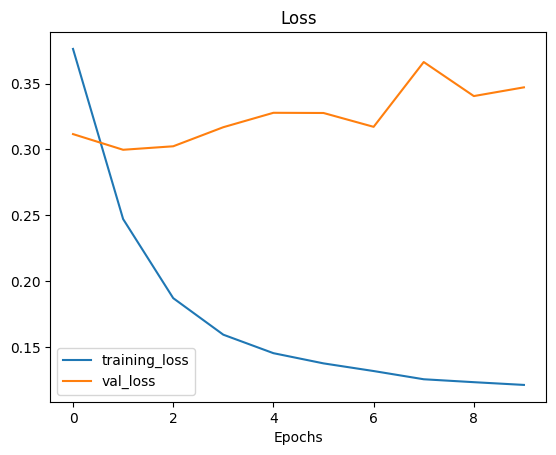

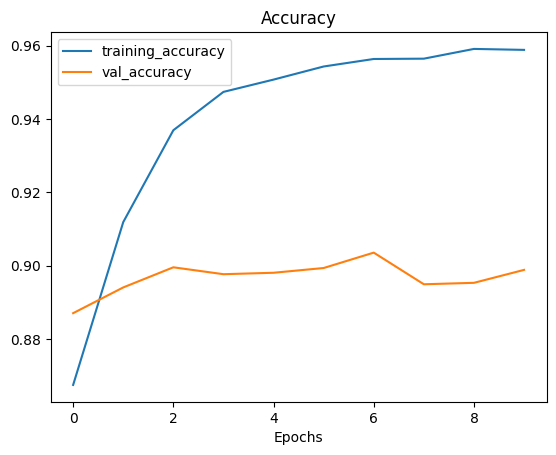

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import pickle
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys
# Create directory to save tf logs
SAVE_DIR = "model_logs/rnn"

# Create a simple RNN model
model = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=X_train.shape[1]),
    SimpleRNN(units=128),
    Dense(units=num_classes, activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

subset_size = len(X_train) // 10  # Use 10% of the data
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]

# Fit the model
history = model.fit(X_train_subset, y_train_subset, validation_data=(X_val, y_val), epochs=10, callbacks=[create_tensorboard_callback(SAVE_DIR,"base_rnn")])

# Evaluate the model
model.evaluate(X_test, y_test)


In [ ]:
# Get numbers like f1 score, precision, recall
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred), sep='\n')
# Print final values precision f1
print("Final training loss: {:.4f}".format(history.history['loss'][-1]))
print("Final validation loss: {:.4f}".format(history.history['val_loss'][-1]))
print("Final training accuracy: {:.4f}".format(history.history['accuracy'][-1]))
print("Final validation accuracy: {:.4f}".format(history.history['val_accuracy'][-1]))
print("Final test accuracy: {:.4f}".format(model.evaluate(X_test, y_test)[1]))
print("Final test loss: {:.4f}".format(model.evaluate(X_test, y_test)[0]))
print("Final test f1 score: {:.4f}".format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[2]))
print("Final test precision: {:.4f}".format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[0]))
print("Final test recall: {:.4f}".format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[1]))


1452/1452 [==============================] - 14s 9ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     38323
           1       0.55      0.33      0.41      2491
           2       0.52      0.51      0.52      1919
           3       0.34      0.27      0.30       909
           4       0.60      0.75      0.67      2773
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         6

    accuracy                           0.89     46435
   macro avg       0.37      0.35      0.36     46435
weighted avg       0.88      0.89      0.88     46435

Final training loss: 0.1213
Final validation loss: 0.3471
Final training accuracy: 0.9589
Final validation accuracy: 0.8989
   1/1452 [..............................] - ETA: 40s - loss: 0.8195 - accuracy: 0.6250

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1452/1452 [==============================] - 6s 4ms/step - loss: 0.4034 - accuracy: 0.8856
Final test accuracy: 0.8856
1452/1452 [==============================] - 6s 4ms/step - loss: 0.4034 - accuracy: 0.8856
Final test loss: 0.4034
Final test f1 score: 0.8801
Final test precision: 0.8789
Final test recall: 0.8856


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 128)            51200640  
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
Total params: 51234568 (195.44 MB)
Trainable params: 51234568 (195.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow import keras
# Save the model
model.save('saved_model/simple_rnn_ner')
print("Model saved to 'saved_model/simple_rnn_ner'")

# Load the model
model = keras.models.load_model('saved_model/simple_rnn_ner')
print("Model loaded from 'saved_model/simple_rnn_ner'")
# GET model size
model_size = model.count_params()
print("Model size:", model_size)
# model size in mb
model_size_mb = model_size / (1024 * 1024)
print("Model size in MB:", model_size_mb)




Model saved to 'saved_model/simple_rnn_ner'
Model loaded from 'saved_model/simple_rnn_ner'
Model size: 51234568


In [ ]:
model_size_mb = model_size / (1024 * 1024)
print("Model size in MB:", model_size_mb)
# get training time and inference time
import time
start_time = time.time()
model.predict(X_test)
end_time = time.time()
training_time = end_time - start_time
print("Training time:", training_time)
#inference time
start_time = time.time()
model.predict(X_test)
end_time = time.time()
inference_time = end_time - start_time
print("Inference time:", inference_time)

Model size in MB: 48.86109161376953
1452/1452 [==============================] - 11s 8ms/step
Training time: 20.69799494743347
1452/1452 [==============================] - 5s 4ms/step
Inference time: 10.312046766281128


2. LSTM

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

SAVE_DIR = "model_logs/lstm"

# Define the input layer
inputs = layers.Input(shape=(X_train.shape[1],))

# Build the model
x = layers.Embedding(vocab_size, 128)(inputs)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create the model
model_1 = Model(inputs=inputs, outputs=outputs)

# Compile the model
model_1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Prepare the subset of data
subset_size = len(X_train) // 10  # Use 10% of the data
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]

# Train the model
history_1 = model_1.fit(
    X_train_subset,
    y_train_subset,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=[create_tensorboard_callback(SAVE_DIR, "lstm")]
)

Saving TensorBoard log files to: model_logs/lstm/lstm/20240719-060623
Epoch 1/10
718/718 [==============================] - 1324s 2s/step - loss: 0.5092 - accuracy: 0.8341 - val_loss: 0.3690 - val_accuracy: 0.8582
Epoch 2/10
718/718 [==============================] - 1520s 2s/step - loss: 0.3289 - accuracy: 0.8723 - val_loss: 0.3233 - val_accuracy: 0.8797
Epoch 3/10
718/718 [==============================] - 1426s 2s/step - loss: 0.2689 - accuracy: 0.9018 - val_loss: 0.3014 - val_accuracy: 0.8948
Epoch 4/10
718/718 [==============================] - 1350s 2s/step - loss: 0.2322 - accuracy: 0.9169 - val_loss: 0.2981 - val_accuracy: 0.8978
Epoch 5/10
718/718 [==============================] - 1297s 2s/step - loss: 0.2030 - accuracy: 0.9297 - val_loss: 0.3064 - val_accuracy: 0.8960
Epoch 6/10
718/718 [==============================] - 1545s 2s/step - loss: 0.1817 - accuracy: 0.9390 - val_loss: 0.3065 - val_accuracy: 0.9011
Epoch 7/10
718/718 [==============================] - 1494s 2s/ste

1452/1452 [==============================] - 24s 15ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.96      0.97      0.96     38323
           1       0.45      0.47      0.46      2491
           2       0.55      0.45      0.49      1919
           3       0.32      0.32      0.32       909
           4       0.67      0.70      0.68      2773
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         6

    accuracy                           0.89     46435
   macro avg       0.37      0.36      0.36     46435
weighted avg       0.89      0.89      0.89     46435



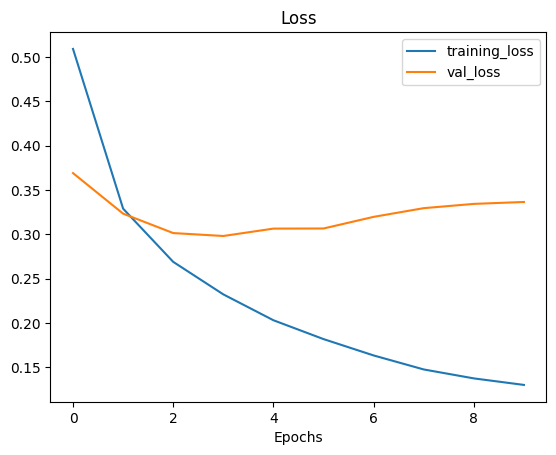

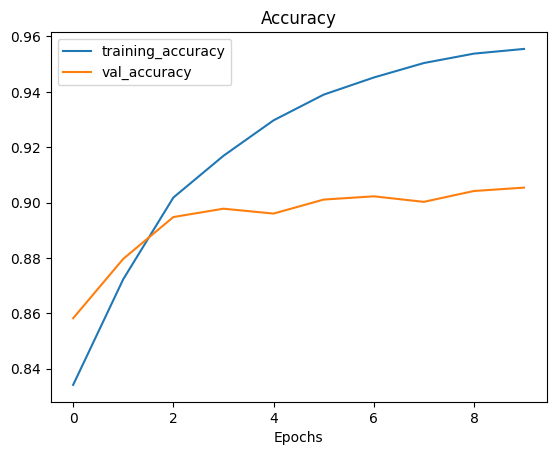

In [ ]:
# Evaluate the model
model_1.evaluate(X_test, y_test)

# Plot the loss curves
plot_loss_curves(history_1)

# Get and plot other metrics like f1 sore, precision, recall
y_pred = model_1.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

In [ ]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5)]               0         
                                                                 
 embedding_3 (Embedding)     (None, 5, 128)            51200640  
                                                                 
 lstm_4 (LSTM)               (None, 5, 128)            131584    
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 51464840 (196.32 MB)
Trainable params: 51464840 (196.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
y_pred = model_1.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

1452/1452 [==============================] - 23s 16ms/step


In [ ]:
print(classification_report(y_test, y_pred), sep='\n')

# The rest of your code remains the same
print("Final training loss: {:.4f}".format(history_1.history['loss'][-1]))
print("Final validation loss: {:.4f}".format(history_1.history['val_loss'][-1]))
print("Final training accuracy: {:.4f}".format(history_1.history['accuracy'][-1]))
print("Final validation accuracy: {:.4f}".format(history_1.history['val_accuracy'][-1]))
print("Final test accuracy: {:.4f}".format(model_1.evaluate(X_test, y_test)[1]))
print("Final test loss: {:.4f}".format(model_1.evaluate(X_test, y_test)[0]))
print("Final test f1 score: {:.4f}".format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[2]))
print("Final test precision: {:.4f}".format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[0]))
print("Final test recall: {:.4f}".format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[1]))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.96      0.97      0.96     38323
           1       0.45      0.47      0.46      2491
           2       0.55      0.45      0.49      1919
           3       0.32      0.32      0.32       909
           4       0.67      0.70      0.68      2773
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         6

    accuracy                           0.89     46435
   macro avg       0.37      0.36      0.36     46435
weighted avg       0.89      0.89      0.89     46435

Final training loss: 0.1300
Final validation loss: 0.3365
Final training accuracy: 0.9555
Final validation accuracy: 0.9054
1452/1452 [==============================] - 31s 19ms/step - loss: 0.3851 - accuracy: 0.8888
Final test accuracy: 0.8888
1452/1452 [==============================] - 20s 13ms/step - loss: 0.3851 - accuracy: 0.8888
Final test 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Save the above model
model_1.save('saved_model/lstm_ner')
print("Model saved to 'saved_model/lstm_ner'")

# Load the model
model_1 = keras.models.load_model('saved_model/lstm_ner')
print("Model loaded from 'saved_model/lstm_ner'")

Model saved to 'saved_model/lstm_ner'
Model loaded from 'saved_model/lstm_ner'


In [ ]:
# Getting size, inference and training time (avg 3values)
import time
import numpy as np

# Measure inference time for 10 iterations
inference_times = []
for _ in range(10):
    start_time = time.time()
    model_1.predict(X_test)
    end_time = time.time()
    inference_times.append(end_time - start_time)

average_inference_time = np.mean(inference_times)
print(f"Average inference time over 10 iterations: {average_inference_time:.4f} seconds")

1452/1452 [==============================] - 20s 14ms/step
Average inference time over 10 iterations: 21.7868 seconds


## GRU

In [10]:
# Building a GRU network
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

SAVE_DIR = "model_logs/gru"

# Define the input layer
inputs = layers.Input(shape=(X_train.shape[1],))

# Build the model
x = layers.Embedding(vocab_size, 128)(inputs)
x = layers.GRU(128, return_sequences=True)(x)
x = layers.GRU(128)(x)
x = layers.Dense(num_classes, activation='softmax')(x)

# Create Model
model_2 = Model(inputs=inputs, outputs=x)

# Compile the model
model_2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Prepare the subset of data
subset_size = len(X_train) // 10  # Use 10% of the data
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]

# Train the model
history_2 = model_2.fit(
    X_train_subset,
    y_train_subset,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=[create_tensorboard_callback(SAVE_DIR, "gru")]
)

Saving TensorBoard log files to: model_logs/gru/gru/20240720-010404
Epoch 1/10
718/718 [==============================] - 1681s 2s/step - loss: 0.4450 - accuracy: 0.8540 - val_loss: 0.3099 - val_accuracy: 0.8799
Epoch 2/10
718/718 [==============================] - 1654s 2s/step - loss: 0.2632 - accuracy: 0.9079 - val_loss: 0.2749 - val_accuracy: 0.9023
Epoch 3/10
718/718 [==============================] - 1599s 2s/step - loss: 0.2001 - accuracy: 0.9312 - val_loss: 0.2816 - val_accuracy: 0.9016
Epoch 4/10
718/718 [==============================] - 1607s 2s/step - loss: 0.1634 - accuracy: 0.9451 - val_loss: 0.3036 - val_accuracy: 0.9035
Epoch 5/10
718/718 [==============================] - 1616s 2s/step - loss: 0.1455 - accuracy: 0.9516 - val_loss: 0.3038 - val_accuracy: 0.9034
Epoch 6/10
718/718 [==============================] - 1453s 2s/step - loss: 0.1334 - accuracy: 0.9549 - val_loss: 0.3255 - val_accuracy: 0.9068
Epoch 7/10
718/718 [==============================] - 1331s 2s/step 

1452/1452 [==============================] - 11s 8ms/step - loss: 0.4084 - accuracy: 0.8892


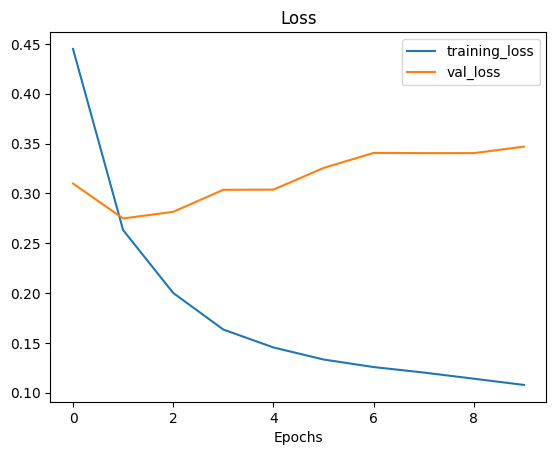

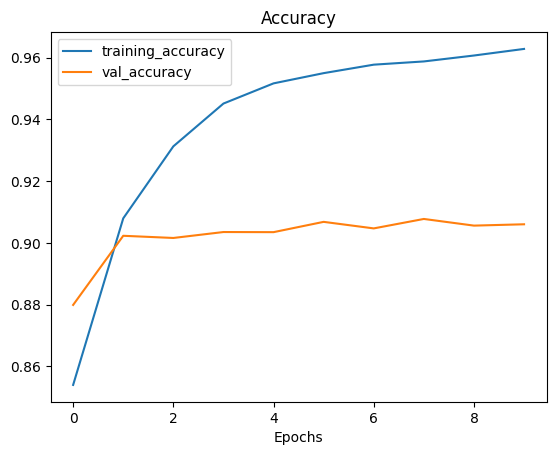

In [11]:
# Evaluate model
model_2.evaluate(X_test, y_test)

# Plot the loss curves
plot_loss_curves(history_2)

In [12]:
y_pred = model_2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

1452/1452 [==============================] - 10s 6ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     38323
           1       0.50      0.41      0.45      2491
           2       0.49      0.52      0.51      1919
           3       0.31      0.34      0.32       909
           4       0.71      0.69      0.70      2773
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         6

    accuracy                           0.89     46435
   macro avg       0.37      0.37      0.37     46435
weighted avg       0.89      0.89      0.89     46435



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 embedding (Embedding)       (None, 5, 128)            51200640  
                                                                 
 gru (GRU)                   (None, 5, 128)            99072     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
Total params: 51399816 (196.07 MB)
Trainable params: 51399816 (196.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# The rest of your code remains the same
print("Final training loss: {:.4f}".format(history_2.history['loss'][-1]))
print("Final validation loss: {:.4f}".format(history_2.history['val_loss'][-1]))
print("Final training accuracy: {:.4f}".format(history_2.history['accuracy'][-1]))
print("Final validation accuracy: {:.4f}".format(history_2.history['val_accuracy'][-1]))
print("Final test accuracy: {:.4f}".format(model_2.evaluate(X_test, y_test)[1]))
print("Final test loss: {:.4f}".format(model_2.evaluate(X_test, y_test)[0]))
print("Final test f1 score: {:.4f}".format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[2]))
print("Final test precision: {:.4f}".format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[0]))
print("Final test recall: {:.4f}".format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[1]))

Final training loss: 0.1079
Final validation loss: 0.3469
Final training accuracy: 0.9628
Final validation accuracy: 0.9060
1452/1452 [==============================] - 10s 7ms/step - loss: 0.4084 - accuracy: 0.8892
Final test accuracy: 0.8892
1452/1452 [==============================] - 10s 7ms/step - loss: 0.4084 - accuracy: 0.8892
Final test loss: 0.4084
Final test f1 score: 0.8875
Final test precision: 0.8864
Final test recall: 0.8892


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
import time
import numpy as np

# Measure inference time for 10 iterations
inference_times = []
for _ in range(10):
    start_time = time.time()
    model_2.predict(X_test)
    end_time = time.time()
    inference_times.append(end_time - start_time)

average_inference_time = np.mean(inference_times)
print(f"Average inference time over 10 iterations: {average_inference_time:.4f} seconds")

# Size of model in mb
model_size = model_2.count_params()
model_size_mb = model_size / (1024 * 1024)
print("Model size in MB:", model_size_mb)

1452/1452 [==============================] - 9s 6ms/step
Average inference time over 10 iterations: 13.9404 seconds
Model size in MB: 49.01868438720703


In [17]:
from tensorflow import keras
# Save model
model_2.save('saved_model/gru_ner')
print("Model saved to 'saved_model/gru_ner'")

# Load model
model_2 = keras.models.load_model('saved_model/gru_ner')
print("Model loaded from 'saved_model/gru_ner'")

Model saved to 'saved_model/gru_ner'
Model loaded from 'saved_model/gru_ner'


## Bidirectional RNN

In [18]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

x = layers.Embedding(vocab_size, 128)(inputs)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(128))(x)
x = layers.Dense(num_classes, activation='softmax')(x)

# Create Model
model_3 = Model(inputs=inputs, outputs=x)

# Compile the model
model_3.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Prepare the subset of data
subset_size = len(X_train) // 10  # Use 10% of the data
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]

# Train the model
history_3 = model_3.fit(
    X_train_subset,
    y_train_subset,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_rnn")]
)

Saving TensorBoard log files to: model_logs/gru/bidirectional_rnn/20240720-052439
Epoch 1/10
718/718 [==============================] - 1525s 2s/step - loss: 0.4857 - accuracy: 0.8414 - val_loss: 0.3997 - val_accuracy: 0.8655
Epoch 2/10
718/718 [==============================] - 1641s 2s/step - loss: 0.3011 - accuracy: 0.8884 - val_loss: 0.3008 - val_accuracy: 0.8914
Epoch 3/10
718/718 [==============================] - 1643s 2s/step - loss: 0.2160 - accuracy: 0.9237 - val_loss: 0.2906 - val_accuracy: 0.9052
Epoch 4/10
718/718 [==============================] - 1627s 2s/step - loss: 0.1748 - accuracy: 0.9422 - val_loss: 0.2968 - val_accuracy: 0.9060
Epoch 5/10
718/718 [==============================] - 1631s 2s/step - loss: 0.1519 - accuracy: 0.9495 - val_loss: 0.3011 - val_accuracy: 0.9062
Epoch 6/10
718/718 [==============================] - 1621s 2s/step - loss: 0.1360 - accuracy: 0.9556 - val_loss: 0.3130 - val_accuracy: 0.9040
Epoch 7/10
718/718 [==============================] - 

1452/1452 [==============================] - 30s 21ms/step - loss: 0.4179 - accuracy: 0.8899


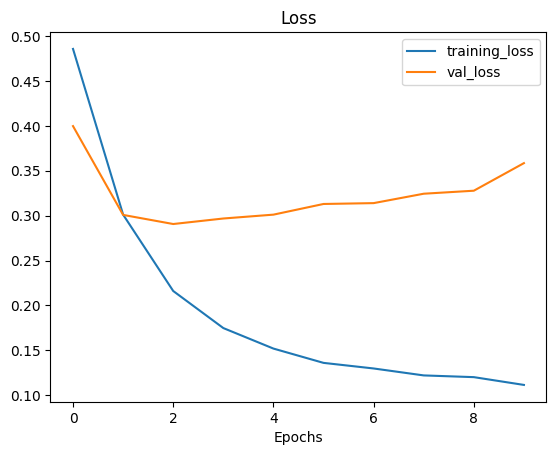

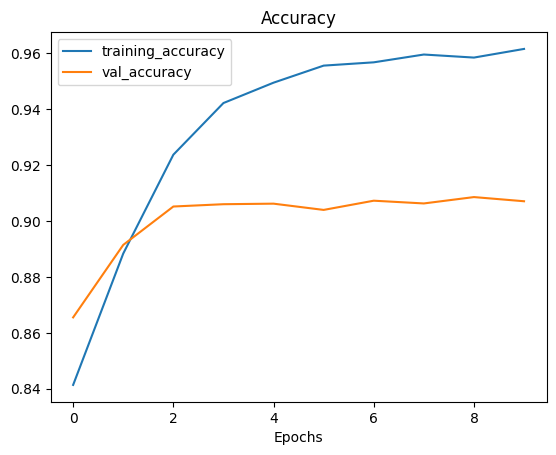

In [19]:
model_3.evaluate(X_test, y_test)

plot_loss_curves(history_3)


In [20]:
y_pred = model_3.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

1452/1452 [==============================] - 46s 27ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     38323
           1       0.51      0.43      0.47      2491
           2       0.53      0.54      0.53      1919
           3       0.30      0.35      0.33       909
           4       0.63      0.71      0.67      2773
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         6

    accuracy                           0.89     46435
   macro avg       0.37      0.37      0.37     46435
weighted avg       0.89      0.89      0.89     46435



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 embedding_1 (Embedding)     (None, 5, 128)            51200640  
                                                                 
 bidirectional (Bidirection  (None, 5, 256)            263168    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 51860104 (197.83 MB)
Trainable params: 518601

In [22]:
# The rest of your code remains the same
print("Final training loss: {:.4f}".format(history_3.history['loss'][-1]))
print("Final validation loss: {:.4f}".format(history_3.history['val_loss'][-1]))
print("Final training accuracy: {:.4f}".format(history_3.history['accuracy'][-1]))
print("Final validation accuracy: {:.4f}".format(history_3.history['val_accuracy'][-1]))
print("Final test accuracy: {:.4f}".format(model_3.evaluate(X_test, y_test)[1]))
print("Final test loss: {:.4f}".format(model_3.evaluate(X_test, y_test)[0]))
print("Final test f1 score: {:.4f}".format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[2]))
print("Final test precision: {:.4f}".format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[0]))
print("Final test recall: {:.4f}".format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[1]))

Final training loss: 0.1114
Final validation loss: 0.3585
Final training accuracy: 0.9615
Final validation accuracy: 0.9071
1452/1452 [==============================] - 37s 25ms/step - loss: 0.4179 - accuracy: 0.8899
Final test accuracy: 0.8899
1452/1452 [==============================] - 31s 22ms/step - loss: 0.4179 - accuracy: 0.8899
Final test loss: 0.4179
Final test f1 score: 0.8898
Final test precision: 0.8904
Final test recall: 0.8899


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
import time
import numpy as np

# Measure inference time for 10 iterations
inference_times = []
for _ in range(10):
    start_time = time.time()
    model_3.predict(X_test)
    end_time = time.time()
    inference_times.append(end_time - start_time)

average_inference_time = np.mean(inference_times)
print(f"Average inference time over 10 iterations: {average_inference_time:.4f} seconds")

# Size of model in mb
model_size = model_3.count_params()
model_size_mb = model_size / (1024 * 1024)
print("Model size in MB:", model_size_mb)

1452/1452 [==============================] - 37s 25ms/step
Average inference time over 10 iterations: 40.0588 seconds
Model size in MB: 49.45764923095703
